In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PINN.European import EuropeanPINN, V_BS

BS PDE
$$
\frac{\partial V}{\partial \tau}-\frac{\sigma^2 S^2}{2} \frac{\partial^2 V}{\partial S^2}-r S \frac{\partial V}{\partial S}+r V=0.
$$

For European put option, we have initial and boundary conditions
$$
V(S, 0) = (K - S)^+, V(0, \tau) = Ke^{-r\tau}, V(\infty, \tau) = 0.
$$

For European options, we have analytic solutions
$$
V(S, \tau)=K e^{-r \tau}\left(1-N\left(d_2\right)\right)+\left(N\left(d_1\right)-1\right) S,
$$
where
$$
d_1=\frac{\log (S / K)+\left(r+0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}, d_2=\frac{\log (S / K)+\left(r-0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}.
$$



In [58]:
# load data
ib = torch.load('data/european_put_ib.pt')
pde = torch.load('data/european_put_pde.pt')
S_ib, tau_ib, V_ib = ib['S'], ib['tau'], ib['V']
S_pde, tau_pde = pde['S'], pde['tau']

# parameters
K = 4
sigma = 0.3
r = 0.03
T = 1
S_inf = 3 * K

Epoch 100/100:
IB Loss: 0.0008889921009540558
PDE Loss: 0.0005357623449526727
Data Loss: 0.0

Epoch 100/200:
IB Loss: 5.873338977835374e-06
PDE Loss: 4.4871562749904115e-06
Data Loss: 0.0

Epoch 200/200:
IB Loss: 5.873338977835374e-06
PDE Loss: 4.4871562749904115e-06
Data Loss: 0.0



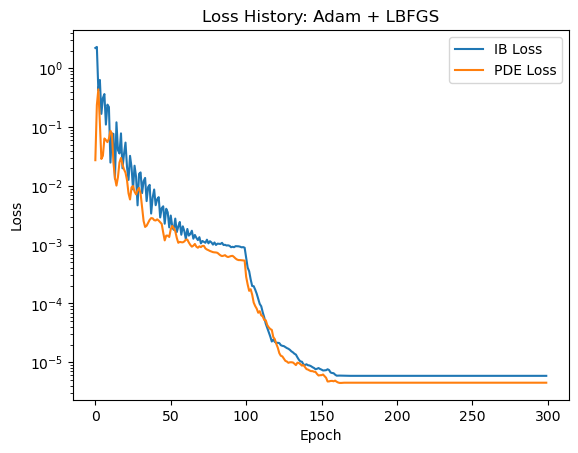

In [59]:
nn = torch.nn.Sequential(
    torch.nn.Linear(2, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 1)
)

model = EuropeanPINN(nn, K, T, r, sigma, S_inf)

# First train with Adam for 100 epochs
model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, epochs=100, optimizer='adam', lr=1e-1)
# Then train with L-BFGS for 200 epochs
model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, epochs=200, optimizer='lbfgs')
model.plot_loss(data=False, range=5000, save=True, title='Loss History: Adam + LBFGS', file_name='european_put_loss_adam_lbfgs.pdf')

# save model
torch.save(model, 'models/european_put_adam_lbfgs.pt')

/Users/liyiyan/Documents/vscode/Option-Pricing-Using-Physics-Informed-Neural-Networks/PINN/European.py:8: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))


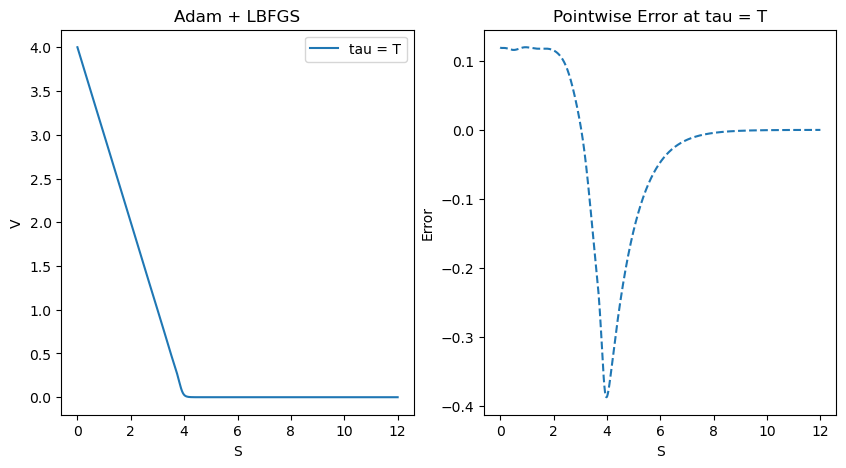

In [61]:
# load model
model = torch.load('models/european_put_adam_lbfgs.pt')

# # plot
# S_plot = torch.linspace(0, 10, 1000)
# tau_plot = torch.linspace(0, T, 1000)
# S_plot, tau_plot = torch.meshgrid(S_plot, tau_plot)
# V_plot = model(S_plot.reshape(-1, 1), tau_plot.reshape(-1, 1)).detach().reshape(1000, 1000)
# # 3d plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(S_plot.numpy(), tau_plot.numpy(), V_plot.numpy())
# ax.set_xlabel('S')
# ax.set_ylabel('tau')
# ax.set_zlabel('V')
# plt.show()

# plot tau = T
S_plot = torch.linspace(0, S_inf, 1000)
V_plot = model(S_plot.reshape(-1, 1), torch.zeros(1000, 1)).reshape(-1).detach()
V_true = V_BS(S_plot.detach().numpy(), tau=T, K=K, r=r, sigma=sigma, type='put')
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(S_plot, V_plot, label='tau = T')
plt.xlabel('S')
plt.ylabel('V')
plt.title('Adam + LBFGS')
plt.legend()

# plot pointwise error at tau = T
plt.subplot(122)
plt.plot(S_plot, V_plot - V_true, ls='--')
plt.xlabel('S')
plt.ylabel('Error')
plt.title('Pointwise Error at tau = T')
plt.show()

In [62]:
import scipy.sparse as sp
from scipy.linalg import solve_banded


def V_BS_crank_nocolson(m, n, T, sigma, r, S_inf, payoff_fn, V_0_tau, V_Sinf_tau):
    # x = logS
    x_L = np.log(1e-16)
    x_U = np.log(S_inf)

    # dt = T / n
    # dx = (x_U - x_L) / m

    alpha = -1/sigma**2 * (r - 0.5*sigma**2)
    beta = -1/2*sigma**2 * (r - 0.5*sigma**2)**2

    # Initialize the solution grid
    u = np.zeros((n + 1, m + 1))

    # Set initial and boundary conditions
    xs = np.linspace(x_L, x_U, m + 1)
    ts = np.linspace(0, T, n + 1)
    u[0, :] = np.exp(-alpha*xs) * payoff_fn(np.exp(xs))
    u[:, 0] = np.exp(-alpha*x_L + (r-beta)*ts) * V_0_tau(ts)
    u[:, -1] = np.exp(-alpha*x_U + (r-beta)*ts) * V_Sinf_tau(ts)

    # consturct matrix
    alpha_sigma2 = alpha * sigma**2
    C_diag = 1 + alpha_sigma2*0.5
    C_sup_diag = -alpha_sigma2*0.25
    D_diag = 1 - alpha_sigma2*0.5
    D_sub_diag = alpha_sigma2*0.25

    # construct tridiag matrix C in diagonal ordered form for banded solver
    C = np.zeros((3, m-1))
    C[0, 1:] = C_sup_diag
    C[1, :] = C_diag
    C[2, :-1] = C_sup_diag

    D = sp.diags([D_diag, D_sub_diag, D_sub_diag], [0, 1, -1], shape=(m-1, m-1))

    # Time-stepping loop
    for i in range(n):
        b = np.zeros(m-1)
        b[0] = (u[i, 0] + u[i+1, 0]) * 0.5
        b[-1] = (u[i, -1] + u[i+ 1, -1]) * 0.5

        # C u_i+1 = D u_i + alpha_sigma2/2 b
        # Solve for u_i+1

        RHS = D.dot(u[i, 1:-1]) + 0.5*alpha_sigma2*b

        u_next = solve_banded((1, 1), C, RHS)

        # Update the solution grid
        u[i+1, 1:-1] = u_next

    S = np.exp(xs)
    V = np.exp((beta-r)*ts) * S**alpha * u
    return V, S, ts

In [63]:
V, S, t = V_BS_crank_nocolson(2000, 2000, T, sigma, r, S_inf,
                              lambda x: np.maximum(K - x, 0), lambda t: K*np.exp(-r*t), lambda t: 0)

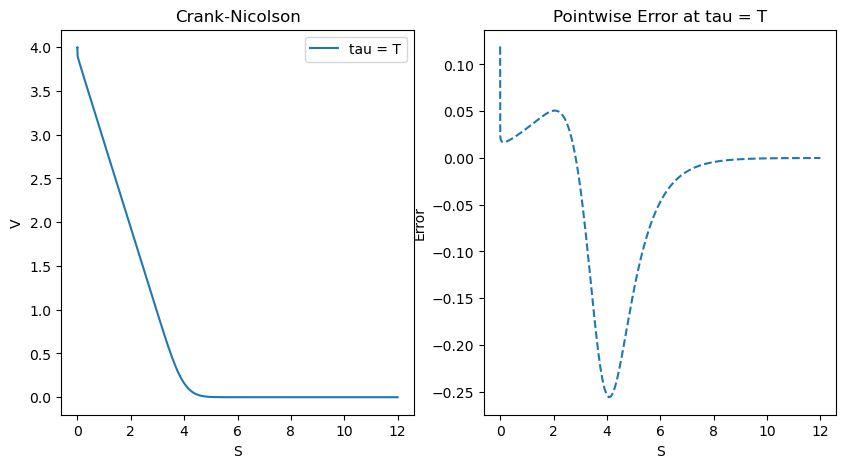

In [67]:
# plot CN solution at tau = T
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(S, V[-1, :], label='tau = T')
plt.xlabel('S')
plt.ylabel('V')
plt.title('Crank-Nicolson')
plt.legend()

# plot pointwise error at tau = T
plt.subplot(122)
V_true = V_BS(S, tau=T, K=K, r=r, sigma=sigma, type='put')
plt.plot(S, V[-1, :] - V_true, ls='--')
plt.xlabel('S')
plt.ylabel('Error')
plt.title('Pointwise Error at tau = T')
plt.show()